In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gaussian3weight/g3w/g3r/G3.h5
/kaggle/input/gaussian3weight/g3w/g3r/RouteGenerator.h5
/kaggle/input/gaussian3weight/g3w/srvalid/541_sat.jpg
/kaggle/input/gaussian3weight/g3w/srvalid/4227_mask.png
/kaggle/input/gaussian3weight/g3w/srvalid/113_sat.jpg
/kaggle/input/gaussian3weight/g3w/srvalid/343_mask.png
/kaggle/input/gaussian3weight/g3w/srvalid/113_mask.png
/kaggle/input/gaussian3weight/g3w/srvalid/2667_sat.jpg
/kaggle/input/gaussian3weight/g3w/srvalid/655_sat.jpg
/kaggle/input/gaussian3weight/g3w/srvalid/388_mask.png
/kaggle/input/gaussian3weight/g3w/srvalid/104_sat.jpg
/kaggle/input/gaussian3weight/g3w/srvalid/562_sat.jpg
/kaggle/input/gaussian3weight/g3w/srvalid/343_sat.jpg
/kaggle/input/gaussian3weight/g3w/srvalid/655_mask.png
/kaggle/input/gaussian3weight/g3w/srvalid/541_mask.png
/kaggle/input/gaussian3weight/g3w/srvalid/4227_sat.jpg
/kaggle/input/gaussian3weight/g3w/srvalid/5668_mask.png
/kaggle/input/gaussian3weight/g3w/srvalid/2667_mask.png
/kaggle/input/gaussian3

In [2]:
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [4]:
from keras.models import load_model

In [5]:
routegenerator = load_model('/kaggle/input/gaussian3weight/g3w/g3r/RouteGenerator.h5')

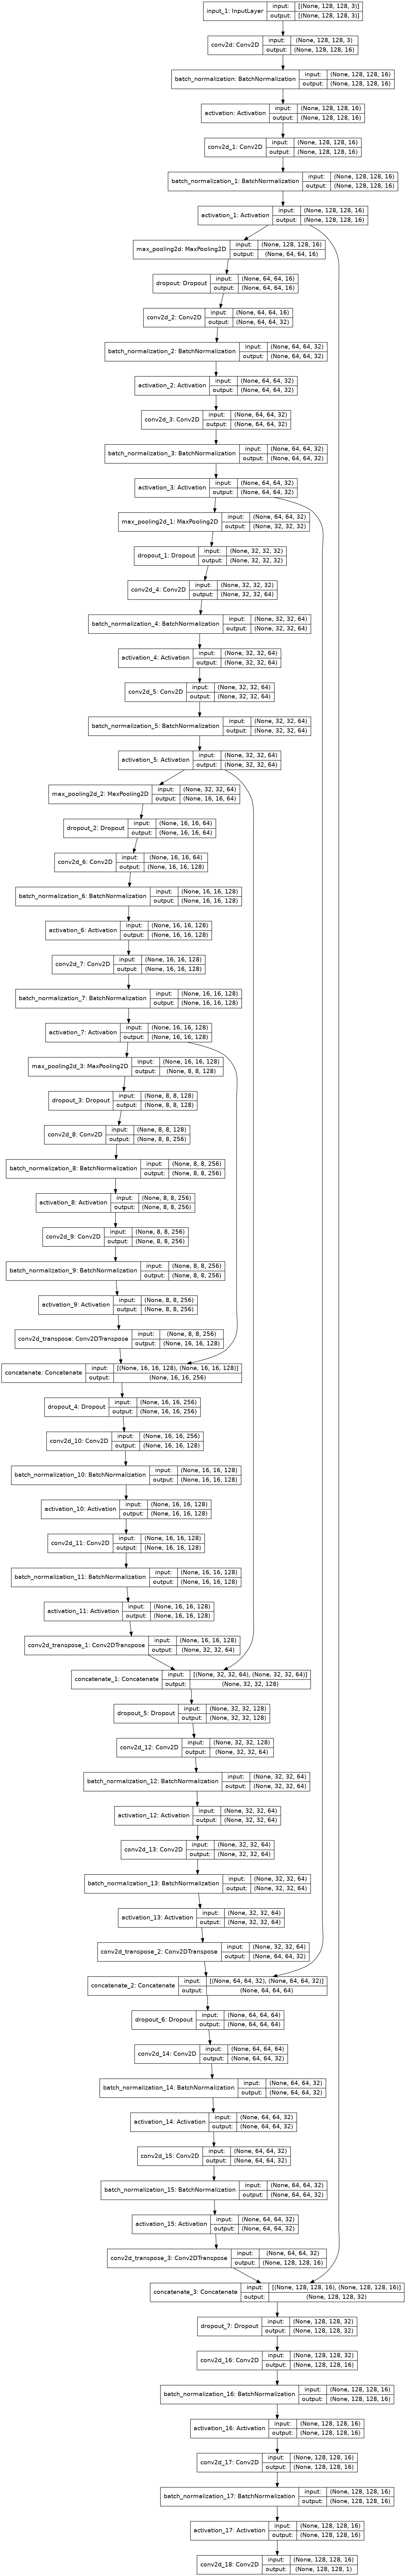

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(routegenerator, to_file='routegenerator.png', show_shapes=True, show_layer_names=True)

In [8]:
routegenerator.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
gaussian3x3sr = load_model('/kaggle/input/gaussian3weight/g3w/g3r/G3.h5')

In [10]:
gaussian3x3sr.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 160, 160, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 160, 160, 128 147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 160, 160, 256 296192      sequential_1[0][0]               
______________________________________________________________________________________________

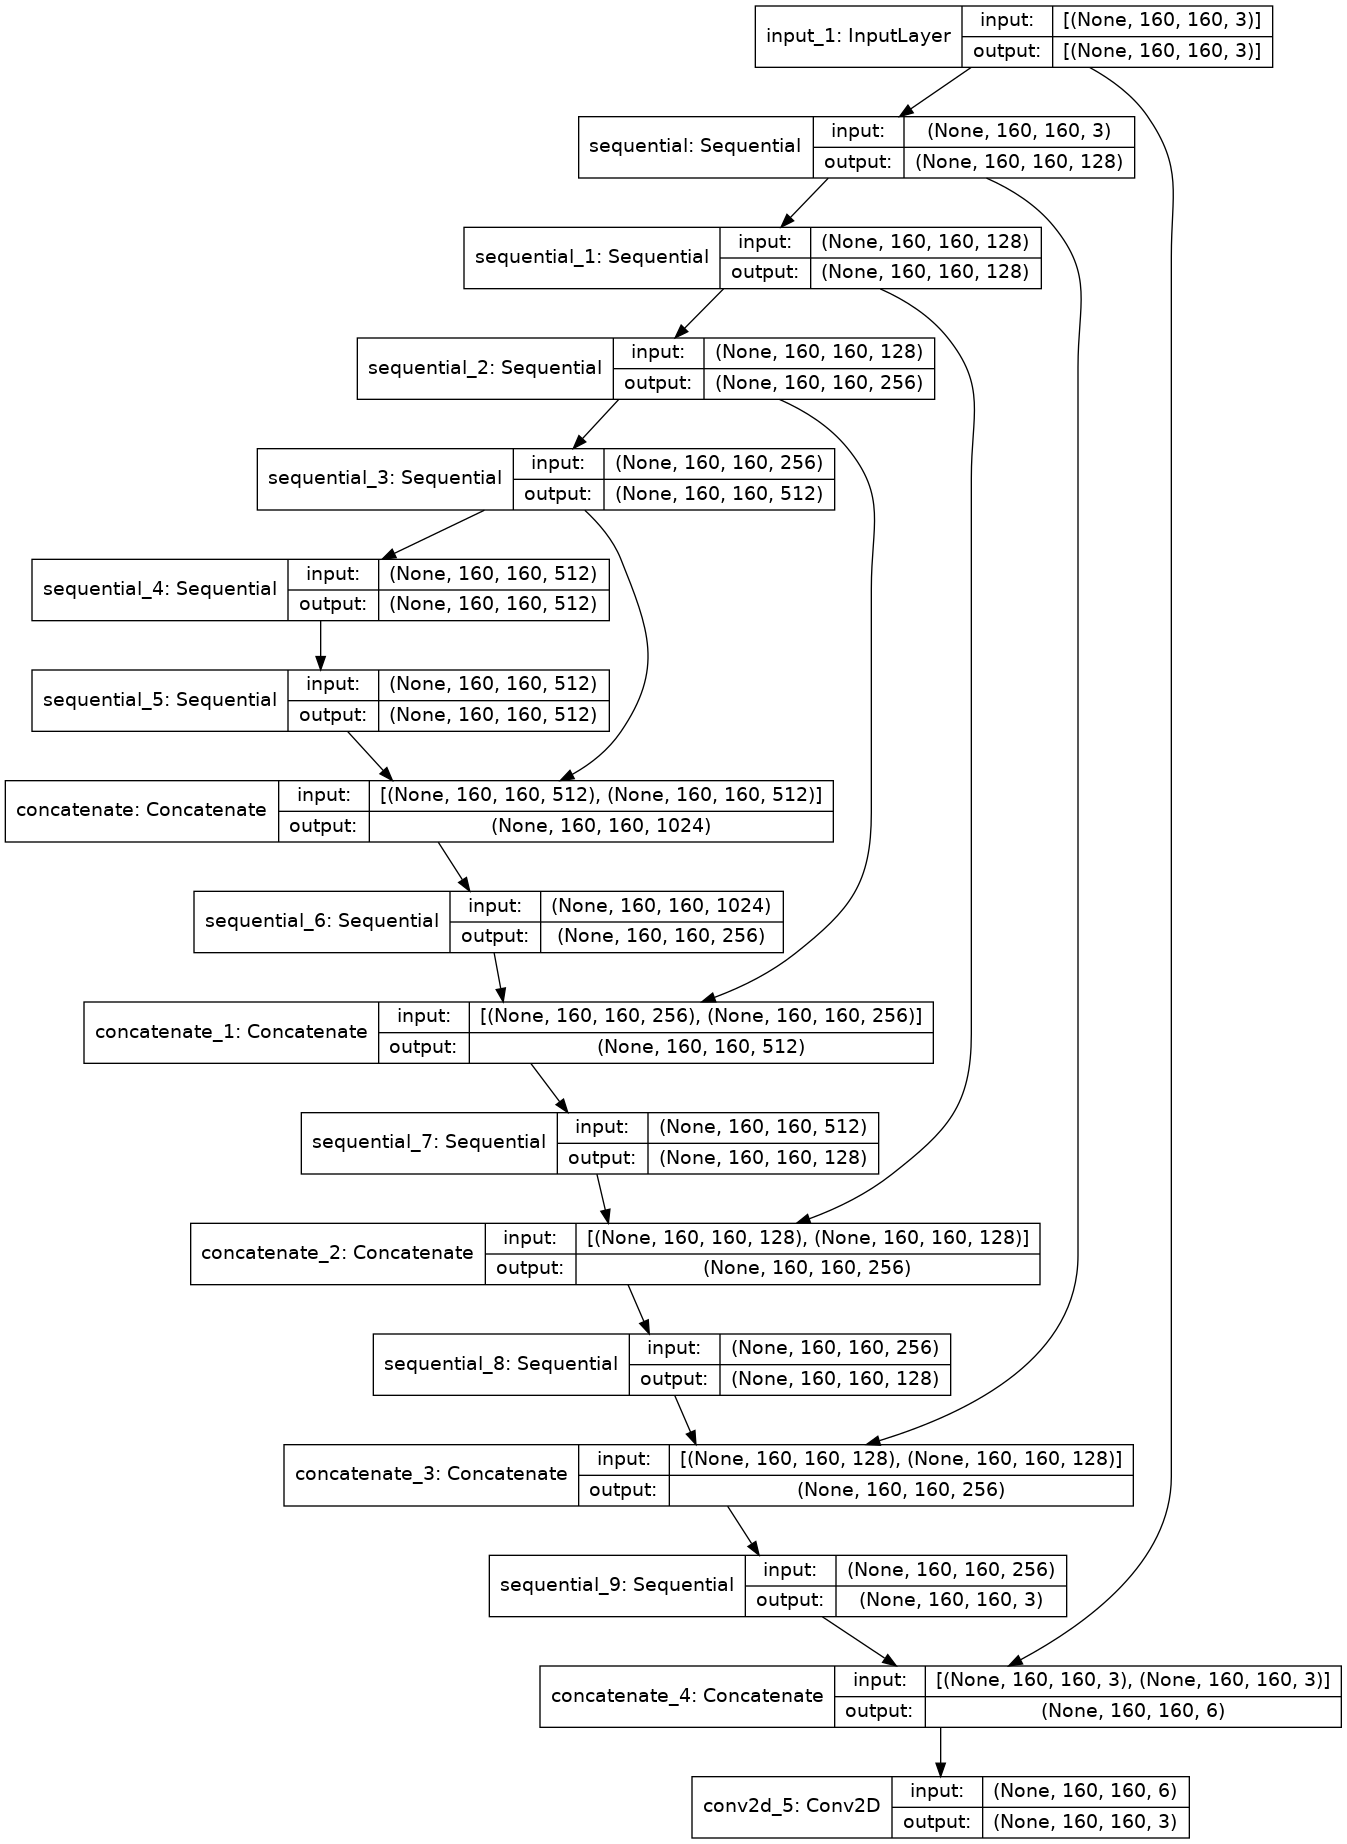

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(gaussian3x3sr, to_file='gaussian3x3sr.png', show_shapes=True, show_layer_names=True)

In [12]:
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/gaussian3weight/g3w/srvalid', 
                        maskPath = '/kaggle/input/gaussian3weight/g3w/srvalid'
                         , shape = 128)

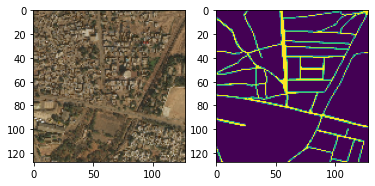

In [13]:
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [14]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from skimage.transform import resize, rescale
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
high_img = []
path = '/kaggle/input/gaussian3weight/g3w/srvalid'
files = os.listdir(path)
files = sorted_alphanumeric(files)
counthigh = 0
countlow = 0
#kernel_3x3 = np.ones((3, 3), np.float32) / 9 #boxblur
# We apply the filter and display the image
 
for i in tqdm(files):    
    if counthigh == 20:
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))
        counthigh = counthigh + 1

"""
low_img = []
path = '/kaggle/input/srfullsat/allhigh/low'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if countlow == 5000:
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT)
        #img = cv2.filter2D(img, -1, kernel_3x3)
        
        low_img.append(img_to_array(img))
        countlow = countlow +1
        """

100%|██████████| 20/20 [00:00<00:00, 45.45it/s]


"\nlow_img = []\npath = '/kaggle/input/srfullsat/allhigh/low'\nfiles = os.listdir(path)\nfiles = sorted_alphanumeric(files)\nfor i in tqdm(files):\n     if countlow == 5000:\n        break\n     else: \n        img = cv2.imread(path + '/'+i,1)\n\n        #resizing image\n        img = cv2.resize(img, (SIZE, SIZE))\n        img = img.astype('float32') / 255.0\n        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n        img = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT)\n        #img = cv2.filter2D(img, -1, kernel_3x3)\n        \n        low_img.append(img_to_array(img))\n        countlow = countlow +1\n        "

In [15]:
test_high_image = high_img[:20]

In [16]:
SIZE = 160
for i in range(1,10):
    predicted = np.clip(gaussian3x3sr.predict(test_high_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)

In [17]:
def predict16 (valMap, model, shape = 128):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = predicted [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask



def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')
    

In [18]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, routegenerator)

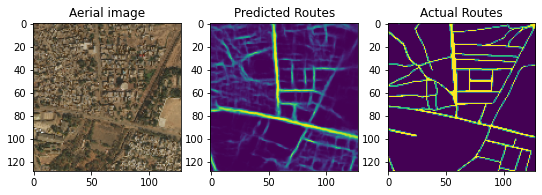

In [19]:
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

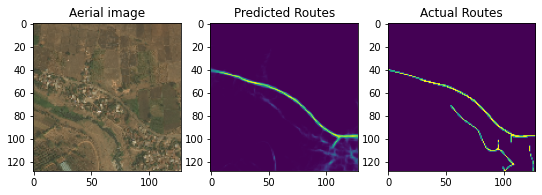

In [20]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

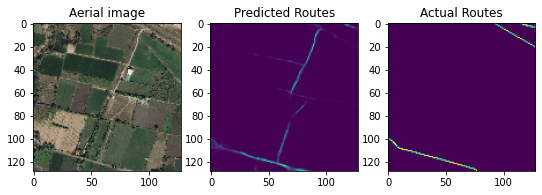

In [21]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

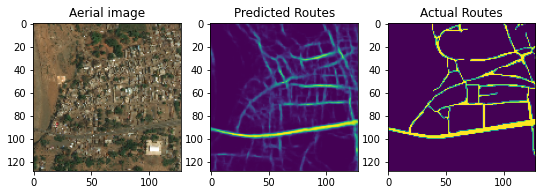

In [22]:
Plotter(actuals[4], sixteenPrediction[4][:,:,0], masks[4])
    

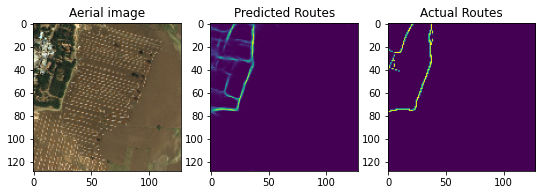

In [23]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

In [ ]:
Plotter(actuals[6], sixteenPrediction[6][:,:,0], masks[6])

In [ ]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

In [ ]:
Plotter(actuals[8], sixteenPrediction[8][:,:,0], masks[8])